# Comparing a USGSCSM and ISIS camera for Dawn FC

In [1]:
import os 
import tempfile
import pvl
os.environ["ISISROOT"] = "/usgs/pkgs/isis3.7.0/install"

import pysis
from pysis import isis

import knoten
from knoten import vis

import json

import ale
from ale import util
from ale.drivers.dawn_drivers import DawnFcPds3NaifSpiceDriver
from ale.formatters.usgscsm_formatter import to_usgscsm

from IPython.display import Image

import plotly
plotly.offline.init_notebook_mode(connected=True)

import numpy as np

class AleJsonEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, set):
            return list(obj)
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        elif isinstance(obj, datetime.date):
            return obj.isoformat()
        return json.JSONEncoder.default(self, obj)

/home/kberry/anaconda3/envs/knoten/lib/python3.7/site-packages/ale/__init__.py:22: UserWarning:

ALESPICEROOT environment variable not set, Spice Drivers will not function correctly



## Make a CSM sensor model

In [2]:
imageLink = 'https://pdsimage.wr.usgs.gov/Missions/Dawn/Ceres/DWNCSFC2_1A/DATA/IMG/20150604_SURVEY/20150617_CYCLE5/FC21A0038582_15170161546F6F.IMG'
!wget -N -P data/ {imageLink}
fileName = 'data/' + os.path.split(imageLink)[1]

camera = knoten.csm.create_csm(fileName)

--2019-10-17 15:51:08--  https://pdsimage.wr.usgs.gov/Missions/Dawn/Ceres/DWNCSFC2_1A/DATA/IMG/20150604_SURVEY/20150617_CYCLE5/FC21A0038582_15170161546F6F.IMG
Resolving pdsimage.wr.usgs.gov (pdsimage.wr.usgs.gov)... 8.27.177.76, 2001:1900:2200:19ff::76
Connecting to pdsimage.wr.usgs.gov (pdsimage.wr.usgs.gov)|8.27.177.76|:443... connected.
HTTP request sent, awaiting response... 304 Not Modified
File ‘data/FC21A0038582_15170161546F6F.IMG’ not modified on server. Omitting download.



## Ingest the image, run spiceinit, and create an isd

In [3]:
# Set the output location of the resulting .cub
cub_loc = os.path.splitext(fileName)[0] + '.cub'

try: 
    isis.dawnfc2isis(from_=fileName, to=cub_loc)
except ProcessError as e:
    print(e.stderr)

try:
    isis.spiceinit(from_=cub_loc, shape='ellipsoid')
except ProcessError as e:
    print(e.stderr)

# probably a better way to do this...
kernels = util.generate_kernels_from_cube(cub_loc)
kernels = [kernel.replace('$dawn', '/usgs/cpkgs/isis3/data/dawn') for kernel in kernels]
kernels = [kernel.replace('$base', '/usgs/cpkgs/isis3/data/base') for kernel in kernels]
#fails, I think until adam's PR gets merged
#usgscsm_isd = ale.load(fileName, props={'kernels': kernels}, formatter='usgscsm', verbose=True)

with DawnFcPds3NaifSpiceDriver(fileName, props={'kernels': kernels}) as driver:
        usgscsm_dict = to_usgscsm(driver)
        csm_isd = os.path.splitext(fileName)[0] + '.json'
        json.dump(usgscsm_dict, open(csm_isd, 'w'), cls=AleJsonEncoder)

## Compute and display differences between USGSCSM and ISIS

In [4]:
csmisis_diff_lv_plot, csmisis_diff_ephem_plot, external_orientation_data = vis.external_orientation_diff(csm_isd, cub_loc, 10, 50, 600, 600)

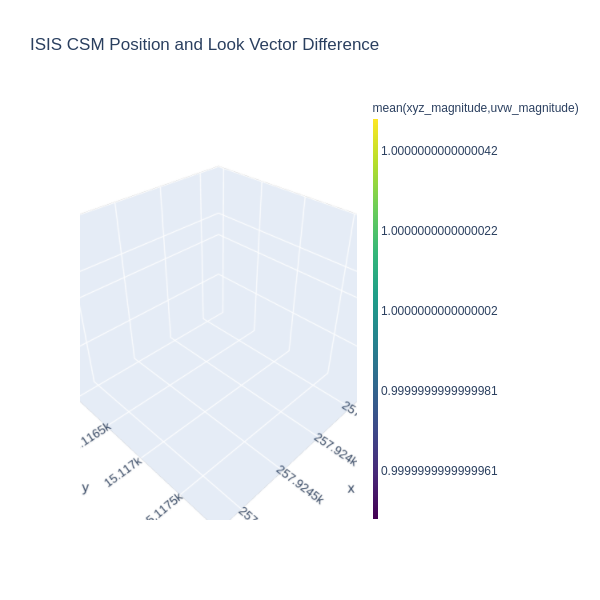

In [5]:
csmisis_diff_lv_plot_bytes = csmisis_diff_lv_plot.to_image(format="png")
csmisis_diff_ephem_plot_bytes = csmisis_diff_ephem_plot.to_image(format="png")
Image(csmisis_diff_lv_plot_bytes)

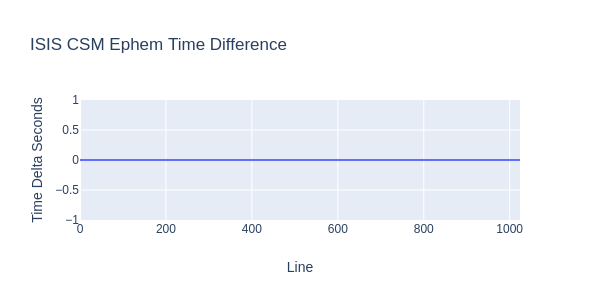

In [6]:
Image(csmisis_diff_ephem_plot_bytes)

In [7]:
external_orientation_data[['diffx', 'diffy', 'diffz', 'diffu', 'diffv', 'diffw']].describe()

,diffx,diffy,diffz,diffu,diffv,diffw
count,5.000000e+02,500.000000,5.000000e+02,500.000000,500.000000,500.000000
mean,2.240413e-07,-0.000004,-2.980232e-08,0.004011,0.002543,0.000577
std,0.000000e+00,0.000000,0.000000e+00,0.023167,0.014654,0.001273
min,2.240413e-07,-0.000004,-2.980232e-08,-0.032290,-0.020426,-0.000804
25%,2.240413e-07,-0.000004,-2.980232e-08,-0.016142,-0.010209,-0.000583
50%,2.240413e-07,-0.000004,-2.980232e-08,0.004028,0.002546,0.000213
75%,2.240413e-07,-0.000004,-2.980232e-08,0.024177,0.015301,0.001557
max,2.240413e-07,-0.000004,-2.980232e-08,0.040255,0.025509,0.003049


In [8]:
isis2csm_plot, csm2isis_plot, isiscsm_plotlatlon, isiscsm_plotbf, isis2csm_data, csm2isis_data, isiscsm_latlondata, isiscsm_bfdata = vis.reprojection_diff(csm_isd, cub_loc, 10, 50, 500, 500)

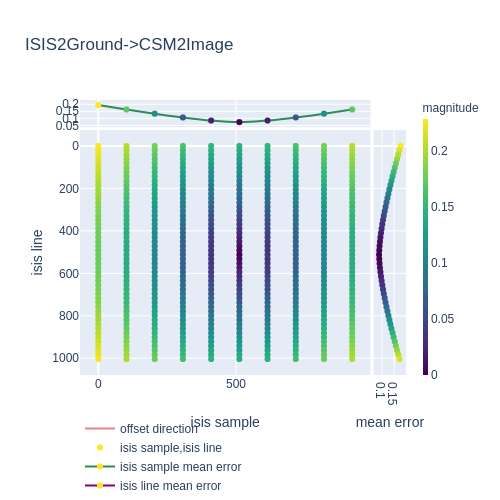

In [9]:
Image(isis2csm_plot.to_image())

In [10]:
isis2csm_data[['diff line', 'diff sample']].describe()

,diff line,diff sample
count,500.000000,500.000000
mean,-0.002932,0.017518
std,0.084624,0.100790
min,-0.146859,-0.140319
25%,-0.076075,-0.070181
50%,-0.002925,0.017525
75%,0.070219,0.105243
max,0.140929,0.175494


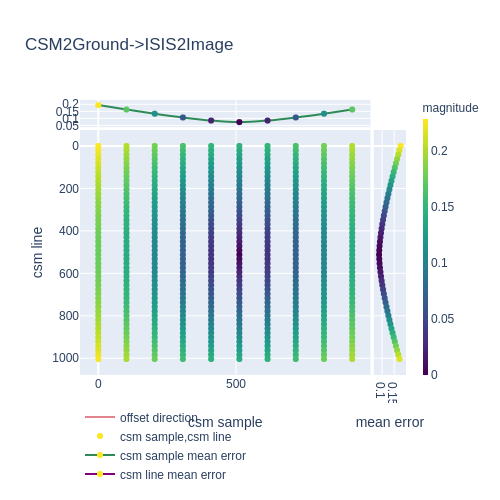

In [11]:
Image(csm2isis_plot.to_image())

In [12]:
csm2isis_data[['diff line', 'diff sample']].describe()

,diff line,diff sample
count,500.000000,500.000000
mean,0.002926,-0.017543
std,0.084518,0.100885
min,-0.140436,-0.175432
25%,-0.070209,-0.105279
50%,0.002925,-0.017543
75%,0.076057,0.070177
max,0.146287,0.140346


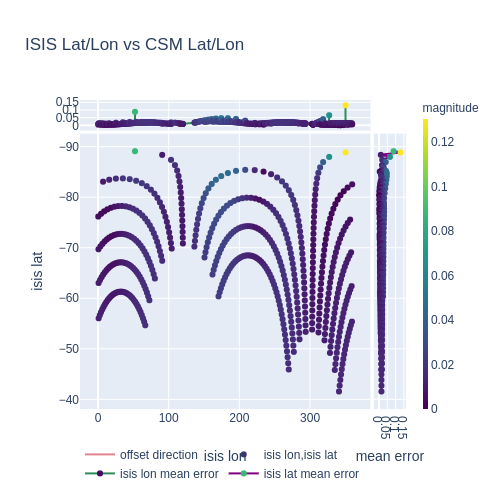

In [13]:
Image(isiscsm_plotlatlon.to_image())

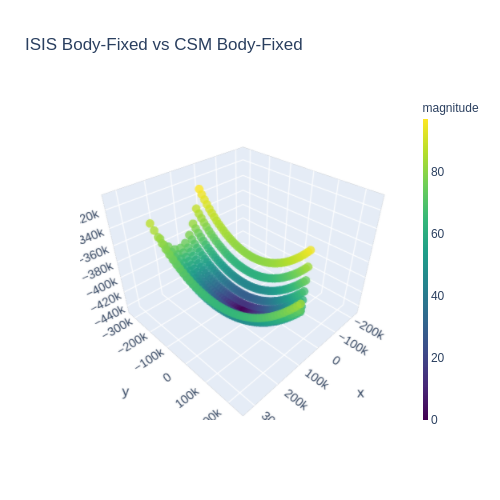

In [14]:
Image(isiscsm_plotbf.to_image())

In [15]:
isiscsm_bfdata[['diffx', 'diffy', 'diffz']].describe()

,diffx,diffy,diffz
count,500.000000,500.000000,500.000000
mean,0.395836,-2.673679,0.959892
std,2.063154,37.570231,14.072064
min,-3.140635,-88.747151,-39.315360
25%,-0.680039,-29.849325,-7.067296
50%,0.169450,-2.857172,0.583751
75%,2.591540,24.558699,10.315661
max,3.139973,84.690162,27.823666
